In [16]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models
import os
import torch
from pathlib import Path
from torch import nn
from torchvision import transforms
from torchinfo import summary
import data_setup
import engine_LRoptim
from helper_functions import plot_save_loss_curves
from padfunc import CustomResizeAndReflectPad
from torchvision.transforms import ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Grayscale
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from datetime import datetime
import json
import pandas as pd


# Set data paths
base_dir = Path("C:/Data/Python/IFCBclassify_MN/")
data_path = Path("C:\Data\Python\IFCB\data")
image_path = Path("C:\Data\Python\IFCB\data\IFCB_test_train")


# # Setup Dirs
# train_dir = image_path / "Train_small"
# test_dir = image_path / "Test_small"
# val_dir = image_path / "Val_small"
# Setup Dirs
train_dir = image_path / "Train_med"
test_dir = image_path / "Test_med"
val_dir = image_path / "Val_med"
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
#print(device)


In [17]:
# Create transforms pipeline
    
train_transform = transforms.Compose([
    CustomResizeAndReflectPad(),  # Apply custom resize, reflect pad, and mirror
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=[0.95, 1.1]),    
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

simple_transform = transforms.Compose([
    CustomResizeAndReflectPad(),  # Apply custom resize, reflect pad, and mirror
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, val_dataloader, test_dataloader, class_names, classes, class_to_idx = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                               val_dir=val_dir,
                                                                                               test_dir=test_dir,
                                                                                               transform=train_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                               simple_transform=simple_transform,
                                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, val_dataloader, test_dataloader, class_names, classes, class_to_idx



(<torch.utils.data.dataloader.DataLoader at 0x2ef46bc7280>,
 ['Achnathes_like_129',
  'Akashiwo_sanguinea_057',
  'Alexandrium_pseudogonyaulax_060',
  'Amphidinium_like_015',
  'Apedinella_radians_031',
  'Asterionellopsis_glacialis_034',
  'Beads_148',
  'Centrales_sideview',
  'Centrales_topview',
  'Cerataulina_pelagica_036',
  'Chaetoceroa_affinis_037',
  'Chaetoceros_contortus_128',
  'Chaetoceros_curvicetus_like_151',
  'Chaetoceros_danicus_039',
  'Chaetoceros_debilis_like_152',
  'Chaetoceros_decipiens_118',
  'Chaetoceros_diadema_136',
  'Chaetoceros_didymus_133',
  'Chaetoceros_phaeoceros_038',
  'Chaetoceros_similis_161',
  'Chaetoceros_socialis_gelidus_040',
  'Chaetoceros_tenuissimus_like_041',
  'Cocconeis_like_124',
  'Cochlodinium_like_150',
  'Coscinodiscus_spp_005',
  'Cryptophyceae_022',
  'Cylindrotheca_closterium_042',
  'Dactyliosolen_fragilissimus_007',
  'Debris_010',
  'Detonula_Lauderia_like_115',
  'Dictyocha_fibula_014',
  'Dinophysis_acuminata_020',
  'Dino

In [19]:
# Make a model

#model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
#model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)
model_1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)


# Freeze base layers
for param in model_1.parameters():
    param.requires_grad = False

# Unfreeze the final layer for training
for param in model_1.fc.parameters():
    param.requires_grad = True

# # Change/add to the classification head (the final part of the network)
# num_ftrs = model_1.fc.in_features
# model_1.fc = nn.Sequential(
#     nn.Dropout(p=0.2),  # Adding a dropout layer with 20% dropout rate to prevent overfitting
#     nn.Linear(num_ftrs, len(class_names))  # Adjust the final layer to have the correct number of output features
# )
# Modify the model by adding two linear layers and dropout layers that are trainable
num_ftrs = model_1.fc.in_features
model_1.fc = nn.Sequential(
    #nn.Linear(num_ftrs, 256),  # First layer, did not achieve much
    #nn.ReLU(),                 # Activation function
    nn.Dropout(p=0.2),         # Dropout layer with 20% dropout rate
    nn.Linear(num_ftrs, len(class_names))  # Output layer with the number of classes
)

# Move model to device
model_1 = model_1.to(device)

model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
#Define a loss and optimizer

loss_fn = nn.CrossEntropyLoss()
initial_lr= 0.001
optimizer = torch.optim.Adam(model_1.parameters(), lr=initial_lr, weight_decay=1e-4)


In [21]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer 
from timeit import default_timer as timer
start_time = timer()


# Setup training and save the results
model_1_results = engine_LRoptim.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5219 | train_acc: 0.2209 | test_loss: 2.3934 | test_acc: 0.5147
Epoch: 2 | train_loss: 2.0156 | train_acc: 0.5690 | test_loss: 1.5655 | test_acc: 0.6544
Epoch: 3 | train_loss: 1.4663 | train_acc: 0.6554 | test_loss: 1.2728 | test_acc: 0.7096
Epoch: 4 | train_loss: 1.2307 | train_acc: 0.7001 | test_loss: 1.0850 | test_acc: 0.7243
Epoch: 5 | train_loss: 1.0787 | train_acc: 0.7174 | test_loss: 1.0008 | test_acc: 0.7463
Epoch: 6 | train_loss: 0.9608 | train_acc: 0.7504 | test_loss: 0.9286 | test_acc: 0.7537
Epoch: 7 | train_loss: 0.8809 | train_acc: 0.7569 | test_loss: 0.8856 | test_acc: 0.7555
Epoch: 8 | train_loss: 0.8214 | train_acc: 0.7830 | test_loss: 0.8687 | test_acc: 0.7721
Epoch: 9 | train_loss: 0.7771 | train_acc: 0.7856 | test_loss: 0.8363 | test_acc: 0.7518
Epoch: 10 | train_loss: 0.7565 | train_acc: 0.7843 | test_loss: 0.8459 | test_acc: 0.7482
Epoch: 11 | train_loss: 0.7366 | train_acc: 0.7830 | test_loss: 0.8132 | test_acc: 0.7665
Epoch: 12 | train_l

In [22]:
# Save the model to
now = datetime.now()
now_str = now.strftime("%Y%m%d_%H%M%S")

model_save_path = base_dir / 'data' / 'models' / f"model_{now_str}"
model_save_path.mkdir(parents=True, exist_ok=True)
model_path = model_save_path / 'model.pth'
torch.save(model_1.state_dict(), model_path)
print(f"Model saved to {model_path}")

figures_path = model_save_path / 'figures'
figures_path.mkdir(parents=True, exist_ok=True)

Model saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240624_154622\model.pth


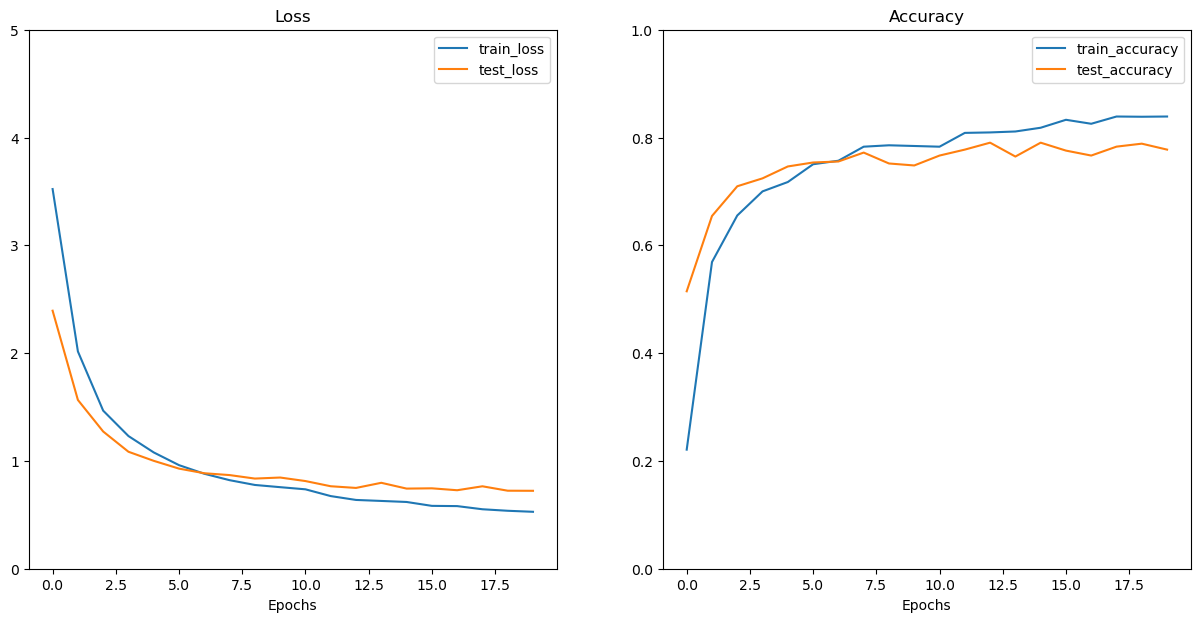

Loss and accuracy curves saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240624_154622\figures\loss_accuracy_curves.png


In [23]:
# Plot the loss curves and save

#Plot the loss urves of model_1
plot_save_loss_curves(model_1_results, save_path=str(figures_path / 'loss_accuracy_curves.png'))

In [24]:


# Save class names JSON file
class_names_path = model_save_path / 'class_names.json'
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)
print(f"Class names saved to {class_names_path}")

# Your class names and indices mapping
class_mapping = class_to_idx

# Save class mapping JSON file
class_mapping_path = model_save_path / 'class_mapping.json'
with open(class_mapping_path, 'w') as json_file:
    json.dump(class_mapping, json_file)
print(f"Class mapping saved to {class_mapping_path}")

Class names saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240624_154622\class_names.json
Class mapping saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240624_154622\class_mapping.json


In [33]:

# Example data to save into CSV
model_name = 'ResNet18'
model_description = 'ResNet18 model with custom final layer'
epochs = 20
optimizer_used = 'Adam'
learning_rate = initial_lr

# Example training results (replace with actual values from your training)
train_loss = model_1_results['train_loss']
train_accuracy = model_1_results['train_acc']
test_loss = model_1_results['test_loss']
test_accuracy = model_1_results['test_acc']

# Combine data into dictionaries
model_data = {
    'Model Name': [model_name],
    'Model Description': [model_description],
    'Epochs': [epochs],
    'Optimizer': [optimizer_used],
    'Learning Rate': [learning_rate]
}

epochs_data = {
    'Epoch': range(1, epochs + 1),
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy
}

# Create DataFrames
df_model_info = pd.DataFrame(model_data)
df_epoch_results = pd.DataFrame(epochs_data)

# Concatenate DataFrames
df_combined = pd.concat([df_model_info, df_epoch_results], axis=1)

# Save to CSV
csv_file = model_save_path / 'model_info.csv'
df_combined.to_csv(csv_file, index=False)
print(f"Model information and epoch results saved to {csv_file}")

Model information and epoch results saved to C:\Data\Python\IFCBclassify_MN\data\models\model_20240624_154622\model_info.csv
